# Predicting NBA Game Outcomes Using Machine Learning

This project aims to develop a sophisticated machine learning model to predict the outcomes of NBA games. By leveraging comprehensive historical data on team and player statistics spanning 10 NBA seasons from 2013-2014 to 2022-2023, the project seeks to uncover hidden patterns and trends that can inform more accurate game outcome predictions.

The key aspects of this project include:

- Introducing player-impact scores for the top 5 performers of each team and a bench impact score to capture individual contributions and team depth.
- Employing advanced feature selection techniques, such as ANOVA F-value feature selection and correlation analysis, to identify the most relevant and non-redundant features.
- Utilizing a Random Forest classifier to handle a large number of features, capture non-linear relationships, and provide robust predictions.
- Evaluating the model's performance using time-series cross-validation and appropriate metrics like accuracy and precision.

By incorporating novel features, domain knowledge, and advanced machine learning techniques, this project aims to improve upon existing NBA game outcome prediction models and contribute to a better understanding of the factors influencing game results.

## Importing Required Libraries

The following code imports the necessary libraries for the project:

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Loading Data from SQLite Database

The following code connects to the SQLite database and loads the data from three tables: `player_stats`, `team_stats`, and `game_info`.

In [2]:
# Connect to the SQLite database
dat = sqlite3.connect('NBA-Boxscore-Database.sqlite')

# LOAD IN PLAYER STATS DATABASE
player_stats = dat.execute("SELECT * FROM player_stats")
cols = [column[0] for column in player_stats.description]
player_stats_df = pd.DataFrame.from_records(data=player_stats.fetchall(), columns=cols)

# LOAD IN TEAM STATS DATABASE
team_stats = dat.execute("SELECT * FROM team_stats")
cols = [column[0] for column in team_stats.description]
team_stats_df = pd.DataFrame.from_records(data=team_stats.fetchall(), columns=cols)

# LOAD IN GAME INFO DATABASE
game_info = dat.execute("SELECT * FROM game_info")
cols = [column[0] for column in game_info.description]
game_info_df = pd.DataFrame.from_records(data=game_info.fetchall(), columns=cols)

## Data Preprocessing

The following code performs data preprocessing steps on the loaded data:

- Merging the game_info and team_info tables to form the primary dataframe that will be used for the remainder of the project (New Dataframe: nba_df).
- Remove player rows player_stats_df where players are not playing, are no longer on the team, or are suspended


In [3]:
nba_df = pd.merge(game_info_df, team_stats_df, on='game_id', how='left').copy()

# Remove BPM, PM and USGp column, as they are all NULL values
# (USGp are all 100 so adds no information)
nba_df = nba_df.drop(columns=['BPM', 'PM', 'USGp'])

# Reset Index of New merged dataframe after merging
nba_df = nba_df.sort_values('date')
nba_df = nba_df.reset_index(drop=True)

# Remove rows with 'Did Not Play', 'Did Not Dress', 'Not With Team', and 
# 'Player Suspended' in the MP column of player_stats_df DataFrame
player_stats_df = player_stats_df[~player_stats_df['MP'].isin(['Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended'])]

# A lot of statistical attributes are empty because players are not playing. 
# Replace and rows left behind with a statistical value of 0
player_stats_df = player_stats_df.fillna(0)

### Uncomment lines below to see new dataset and its respective columns

# nba_df
# player_stats_df
# print("Column Names:", ', '.join(nba_df.columns))


## Data Reshaping: Redefining the Meaning of a Win

The following code reshapes the `nba_df` DataFrame to change the meaning of a win. Instead of representing whether the home team or away team won the game, the 'result' column is modified to indicate whether the team corresponding to each row won the game or not.


In [4]:
# Iterate over each row in the DataFrame
for index, row in nba_df.iterrows():
    # Check if the team is the away team and the result is 1
    if row['team'] == row['away_team'] and row['result'] == 1:
        nba_df.at[index, 'result'] = 0
    # Check if the team is the away team and the result is 0
    elif row['team'] == row['away_team'] and row['result'] == 0:
        nba_df.at[index, 'result'] = 1

# Convert 'result' column to integer type
nba_df['result'] = nba_df['result'].astype(int)
nba_df

,game_id,season,date,away_team,away_score,home_team,home_score,result,team,MP,...,FTr,ORBp,DRBp,TRBp,ASTp,STLp,BLKp,TOVp,ORtg,DRtg
0,131410290001,1314,2013-10-29,ORL,87,IND,97,0,ORL,240,...,0.108,27.7,72.2,47.0,47.2,10.5,11.1,14.9,91.6,102.1
1,131410290001,1314,2013-10-29,ORL,87,IND,97,1,IND,240,...,0.451,27.8,72.3,53.0,50.0,4.2,24.3,19.0,102.1,91.6
2,131410290002,1314,2013-10-29,CHI,95,MIA,107,0,CHI,240,...,0.277,23.9,85.7,50.6,65.7,11.3,7.7,16.2,97.9,110.2
3,131410290002,1314,2013-10-29,CHI,95,MIA,107,1,MIA,240,...,0.403,14.3,76.1,49.4,70.3,10.3,12.3,17.5,110.2,97.9
4,131410290003,1314,2013-10-29,LAC,103,LAL,116,0,LAC,240,...,0.277,22.7,62.5,43.5,65.9,11.0,6.3,14.7,102.6,115.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23953,222304091216,2223,2023-04-09,ATL,114,BOS,120,1,BOS,240,...,0.157,26.1,68.6,48.5,78.6,5.2,5.2,13.6,124.8,118.6
23954,222304091216,2223,2023-04-09,ATL,114,BOS,120,0,ATL,240,...,0.196,31.4,73.9,51.5,61.4,11.4,14.3,7.9,118.6,124.8
23955,222304091230,2223,2023-04-09,GSW,157,POR,101,1,GSW,240,...,0.167,27.3,89.1,65.9,81.0,11.9,10.0,12.7,143.9,92.6
23956,222304091222,2223,2023-04-09,MIL,105,TOR,121,1,TOR,240,...,0.168,18.4,84.4,54.2,60.4,8.1,4.2,8.1,122.1,105.9


## Adding the Target Variable (column: 'target')

To add our target variable of the next game's result, we will shift the next game's result into the previous game's target column, in order to set that as our target variable (the feature that the model will actually be predicting).
- Games at the end of the season where there is no next game will have a null target value. To handle this, the target is changed to 2 (wherever target is null).

In [5]:
def set_target(team):
    team['target'] = team['result'].shift(-1)
    return team

nba_df = nba_df.groupby('team', group_keys = False).apply(set_target)

# Move column to the right of result
target_column = nba_df.pop('target')
result_index = nba_df.columns.get_loc('result')
nba_df.insert(result_index + 1, 'target', target_column)

# Change null values to 2
nba_df.loc[pd.isnull(nba_df['target']), 'target'] = 2

In [6]:
### Uncomment lines below to see the target variable insertion and that the target variable is balanced

# nba_df[nba_df['team'] == 'LAL'].head(200)
# nba_df['result'].value_counts()
# nba_df['target'].value_counts()

## Feature Engineering: Player Impact Score (PIS)

The following code calculates the Player Impact Score (PIS) for each player in the `player_stats_df` DataFrame:

In [7]:
# Define weights for each statistic
weights = {
    'FG': 80.910,
    'STL': 30.897,
    '3P': 90.757,
    'FT': 50.845,
    'BLK': 39.190,
    'ORB': 45.190,
    'AST': 45.677,
    'DRB': 14.707,
    'PF': -6.174,
    'FT_Miss': -12.091,
    'FG_Miss': -30.190,
    'TOV': -53.897
}

# Function to calculate Player Impact Score (PIS) for a single player
def calculate_pis(row):
    # If minutes are 0, set PER to 0
    if row['MP'] == '0:00':
        return 0
    
    # Convert the time format '##:##' into an integer
    mins, secs = map(int, row['MP'].split(':'))
    # Convert to total minutes
    mp = mins + secs / 60
    
    # Calculate PIS using the provided formula
    pis = (
        (row['FG'] * weights['FG'] +
        row['STL'] * weights['STL'] +
        row['3P'] * weights['3P'] +
        row['FT'] * weights['FT'] +
        row['BLK'] * weights['BLK'] +
        row['ORB'] * weights['ORB'] +
        row['AST'] * weights['AST'] +
        row['DRB'] * weights['DRB'] -
        row['PF'] * weights['PF'] -
        (row['FGA'] - row['FG']) * weights['FG_Miss'] -
        (row['FTA'] - row['FT']) * weights['FT_Miss'] -
        row['TOV'] * weights['TOV'])
    )
    return pis

# Apply the function to calculate PIS for every row
player_stats_df['PIS'] = player_stats_df.apply(calculate_pis, axis=1)

# Sort players by PER to identify top performers
player_stats_df = player_stats_df.sort_values(by='PIS', ascending=False)

### Uncomment lines below to see player impact scores

# player_stats_df.head(100)

__Adding Player Impact Scores to the Main DataFrame__

The following code adds the Player Impact Scores (PIS) from the `player_stats_df` DataFrame to the main `nba_df` DataFrame.
- The starting lineup will get their own attribute in the main nba_df (5 players/starts). The starters are determined from the highest minutes played (because the original dataset does not have a 'starter' attribute).
- The bench players (everyone not in the starting lineup) will get a single attribute collectively. This attribute will represent the bench players' aggregated and averaged PIS's.
    - This approach was taken to emphasize the importance of the starting lineup relative to the bench players.


In [8]:
##### Find Starters

player_stats_df['is_starter'] = player_stats_df.groupby(['game_id', 'team'])['MP'].rank(method='dense', ascending=False) <= 5

##### Bench player PIS

bench_stats = player_stats_df[~player_stats_df['is_starter']].groupby(['game_id', 'team'])['PIS'].mean().reset_index()
bench_stats.columns = ['game_id', 'team', 'bench_PIS']

##### Starters PIS

starter_stats = player_stats_df[player_stats_df['is_starter']]
starter_stats = starter_stats[['game_id', 'team', 'player', 'PIS']]
starter_stats['starter_rank'] = starter_stats.groupby(['game_id', 'team'])['PIS'].rank(method='dense', ascending=False)
starter_stats = starter_stats[starter_stats['starter_rank'] <= 5]

##### Convert to Wide Data format (Column for each starter)

starter_stats_pivoted = starter_stats.pivot_table(index=['game_id', 'team'], columns='starter_rank', values='PIS')
starter_stats_pivoted = starter_stats_pivoted.fillna(0)
# Rename Columns
starter_stats_pivoted.columns = [f'starter_{int(col)}_PIS' for col in starter_stats_pivoted.columns]
# Reset index
starter_stats_df = starter_stats_pivoted.reset_index()
# Merge the starter stats with the bench stats
team_stats_df = pd.merge(starter_stats_df, bench_stats, on=['game_id', 'team'])

##### Handle PIS Missing values by taking their teammates averages

# Select the starter columns
starter_cols = [col for col in team_stats_df.columns if col.startswith('starter_') and col.endswith('_PIS')]
# Replace 0 values with NaN
team_stats_df[starter_cols] = team_stats_df[starter_cols].replace(0, np.nan)
# Calculate the average of non-zero values for each row
avg_pis = team_stats_df[starter_cols].mean(axis=1)
# Replace NaN values with the average for each row
team_stats_df[starter_cols] = team_stats_df[starter_cols].apply(lambda x: x.fillna(avg_pis))

##### Merge PIS's into main nba_df dataframe

nba_df = pd.merge(nba_df, team_stats_df, on=['game_id', 'team'], how='left')
nba_df = nba_df.fillna(0)

### Uncomment lines below to see player impact scores in nba_df

# nba_df

## Feature Engineering: Margin of Victory (MOV)

The following code creates a new feature called representing Margin of Victory (MOV) in the `nba_df` DataFrame. The MOV represents the difference between the points scored by a team and their opponent in a given game. Not all victories are created equal. Large point deficits and surpluses provide more information on a team's strength.
* If the team won the game, the MOV value will be a positive integer.
* If the team lost the game, the MOV value will be a negative integer.

In [9]:
# Create the Margin of Victory (MOV) column
nba_df['mov'] = 0  # Initialize MOV column with zeros

# Loop through and calculate differences between home and away scores, respective to the home team
for index, row in nba_df.iterrows():
    if row['team'] == row['home_team']:
        nba_df.at[index, 'mov'] = row['home_score'] - row['away_score']
    elif row['team'] == row['away_team']:
        nba_df.at[index, 'mov'] = row['away_score'] - row['home_score']

# Move the 'MOV' column to the right of the 'result' column
mov_column = nba_df.pop('mov')
result_index = nba_df.columns.get_loc('result')
nba_df.insert(result_index + 1, 'mov', mov_column)

# Score columns are no longer necessary
nba_df = nba_df.drop(columns=['away_score', 'home_score'])

### Uncomment lines below to see 'mov' values in nba_df and ensure it is correctly implemented

# nba_df
# nba_df_filtered = nba_df[(nba_df['mov'] < 0) & (nba_df['result'] > 0)]
# nba_df_filtered

## Data Reshaping: Home/Away Venue Representation

The following code reshapes the `nba_df` DataFrame to standardize the representation of whether a team is playing at home or away. It replaces the 'home_team' and 'away_team' columns with a new 'home' column that indicates if the team for each row played at home or not.

- Home Game: 1
- Away Game: 0

In [10]:
# Sort dataframe by matchup
nba_df = nba_df.sort_values(['game_id'])

# Function that determines whether the team representing a row is playing at home or away
def determine_home(row):
    if row['home_team'] == row['team']:
        return 1
    else:
        return 0

# Create the 'home' column based on the custom function
nba_df['home'] = nba_df.apply(determine_home, axis=1)

# Move column next to date column for readability
home_column = nba_df.pop('home')
date_index = nba_df.columns.get_loc('date')
nba_df.insert(date_index + 1, 'home', home_column)

# Remove the 'home_team' and 'away_team' columns (no longer necessary)
nba_df = nba_df.drop(['home_team', 'away_team'], axis=1)

### Uncomment lines below to see 'home' values in nba_df

# nba_df


## Feature Engineering: Computing Averages of the Last 4 Games

The following code adds new features to the `nba_df` DataFrame by computing the averages of selected stats over the last 4 games for each team.
 - ORtg (Offensive Rating)
 - DRtg (Defensive Rating)
 - TSp (True Shooting Percentage)
 - eFGp (Effective Field Goal Percentage)
 - 3P (3 pointers made)
 - PTS (Total Points scored)
 - starter_#_PIS (Player Impact score for the bench)
 - bench_PIS (Player Impact Score for aggregated bench players)
 
 The new features will have the naming convention that follows: `last_4_{stat}_avg`


In [11]:
# Stats that will be averaged into new features
stats = ['ORtg', 'DRtg', 'TSp', 'eFGp', '3P', 'PTS', 'starter_1_PIS', 'starter_2_PIS','starter_3_PIS','starter_4_PIS','starter_5_PIS','bench_PIS', 'mov']

# This function computes averages for the last 4 games
def compute_averages(group, stats):
    for stat in stats:
        group[f'last_4_{stat}_avg'] = group[stat].shift(1).rolling(window=4, min_periods=1).mean()
        
        # Fill null values with the average of what is available
        group[f'last_4_{stat}_avg'] = group[f'last_4_{stat}_avg'].fillna(group[stat].expanding().mean())
    return group

# Sort the DataFrame by 'season', 'team', and 'game_id'
nba_df = nba_df.sort_values(['season', 'team'])

# Group by 'season', 'team', and 'game_id', and compute the average stats for the last 4 games
team_averages = nba_df.groupby(['season', 'team'], group_keys=False).apply(compute_averages, stats=stats)

# Merge the computed average stats into the main DataFrame
nba_df = pd.merge(nba_df, team_averages[['season', 'team', 'game_id'] + [f'last_4_{stat}_avg' for stat in stats]], on=['season', 'team', 'game_id'], how='left')

In [12]:
### Uncomment lines below to see a sample of the resulting features

# # Assuming nba_df is your DataFrame and selected_columns is defined
# selected_columns = ['game_id', 'team', 'date', 'season', 'starter_1_PIS', 'last_4_starter_1_PIS_avg']
# nba_df = nba_df.sort_values(['game_id'])
# nba_df[nba_df['team'] == 'WAS'][selected_columns].head(30)

## Feature Engineering: Adding Team Record

The following code adds a new feature to the `nba_df` DataFrame that represents the team's record (wins and losses) at the time of each game.


In [13]:
# Function to update the record for a team in a given season
def update_record(row, team_season_records):
    team = row['team']
    season = row['season']
    result = row['result']

    # Initialize the record for the team/season if it doesn't exist
    if team not in team_season_records:
        team_season_records[team] = {}
    if season not in team_season_records[team]:
        team_season_records[team][season] = 0

    # Update the record based on the game result
    if result == 1:
        team_season_records[team][season] += 1  # Increment record for a win
    else:
        team_season_records[team][season] -= 1  # Decrement record for a loss

    return team_season_records[team][season]

# Sort the DataFrame by 'game_id', 'season', and 'team'
nba_df = nba_df.sort_values(by=['game_id', 'season', 'team'])

# Create a new column 'record' and populate it
team_season_records = {}
nba_df['record'] = nba_df.apply(lambda row: update_record(row, team_season_records), axis=1)

In [14]:
### Uncomment lines below to see a sample of the resulting feature

# # Assuming nba_df is your DataFrame and selected_columns is defined
# selected_columns = ['game_id', 'team', 'date', 'season', 'result', 'record']
# nba_df = nba_df.sort_values(['game_id'])
# nba_df[nba_df['team'] == 'WAS'][selected_columns].head(30)

## Feature Engineering: Add Next Game Stats

In this feature engineering step, we add stats about the next game a team is playing (what the model is predicting) to the `nba_df` DataFrame. These stats represent the information that a team would know about their opponent before playing against them in the real world. The features being added are:
- __next_opp_last_4_ORtg_avg__: Average offensive rating of the next opponent over their last 4 games
- __next_opp_last_4_DRtg_avg__: Average defensive rating of the next opponent over their last 4 games
- __next_opp_last_4_TSp_avg__: Average true shooting percentage of the next opponent over their last 4 games
- __next_opp_last_4_eFGp_avg__: Average effective field goal percentage of the next opponent over their last 4 games
- __next_opp_last_4_3P_avg__: Average number of 3-point field goals made by the next opponent over their last 4 games
- __next_opp_last_4_PTS_avg__: Average points scored by the next opponent over their last 4 games
- __next_opp_last_4_starter_1_PIS_avg__: Average Player Impact Score (PIS) of the next opponent's first starter over their last 4 games
- __next_opp_last_4_starter_2_PIS_avg__: Average Player Impact Score (PIS) of the next opponent's second starter over their last 4 games
- __next_opp_last_4_starter_3_PIS_avg__: Average Player Impact Score (PIS) of the next opponent's third starter over their last 4 games
- __next_opp_last_4_starter_4_PIS_avg__: Average Player Impact Score (PIS) of the next opponent's fourth starter over their last 4 games
- __next_opp_last_4_starter_5_PIS_avg__: Average Player Impact Score (PIS) of the next opponent's fifth starter over their last 4 games
- __next_opp_last_4_bench_PIS_avg__: Average Player Impact Score (PIS) of the next opponent's bench players over their last 4 games
- __next_opp_team__: The team that will be the next opponent
- __next_game_home__: Indicates whether the next game is a home game for the team (1) or an away game (0)

In [15]:
##### Define function that returns the opponent teams stats

def get_opponent_stats(df, game_id, team, stats):
    # Find the row for the same game_id but the other team (the opponent)
    # There should only be one
    opponent_rows = df[(df['game_id'] == game_id) & (df['team'] != team)]
    
    # Return an empty dict if opponent is not found
    if opponent_rows.empty:
        return {}
    
    # Get the only opponent row in the list of opponent rows
    opponent_row = opponent_rows.iloc[0]
    
    # Dict to store opponent stats
    opponent_stats = {}
    
    # Retreive opponent stats from opponent row
    for stat in stats:
        opponent_stats[stat] = opponent_row[stat]
    
    # Return Dict of opponent stats
    return opponent_stats

In [16]:
##### Apply function to Dataframe (nba_df)

# Sort the Dataframe by season and team
nba_df = nba_df.sort_values(['season', 'team'])

# Iterate through df
for index, row in nba_df.iterrows():
    # Get the index of the next row (Next game)
    next_index = index + 1
    
    # Check it's not last game
    if next_index < len(nba_df):
        # Get current team
        current_team_row = nba_df.iloc[index]
        current_team = current_team_row['team']
        # Get the next row (next game)
        next_row = nba_df.iloc[next_index]
        # Get the game_id of the next game
        next_game_id = next_row['game_id']
        
        ############################# Add opponent record #############################
        record_values = get_opponent_stats(nba_df, next_game_id, current_team, ['record'])
        result_values = get_opponent_stats(nba_df, next_game_id, current_team, ['result'])
        
        # Remove win/loss from opponents record
        # This is because we can't tell the current team 
        # if the opponent won or lost in the next game they're playing them
        if not record_values or not result_values:
            # If either record null set next_opp_record to null
            nba_df.at[index, 'next_opp_record'] = None
        else:
            record_value = record_values['record']
            result_value = result_values['result']
            if result_value == 1:
                record_value -= 1
            elif result_value == 0:
                record_value += 1
            
            nba_df.at[index, 'next_opp_record'] = record_value

        ############################# Add opponent stats #############################
        opp_stats = get_opponent_stats(nba_df, next_game_id, current_team, ['last_4_ORtg_avg', 'last_4_DRtg_avg', 'last_4_TSp_avg', 'last_4_eFGp_avg',
                    'last_4_3P_avg', 'last_4_PTS_avg', 'last_4_starter_1_PIS_avg', 'last_4_starter_2_PIS_avg', 'last_4_starter_3_PIS_avg', 'last_4_starter_4_PIS_avg', 'last_4_starter_5_PIS_avg', 'last_4_bench_PIS_avg', 'team','last_4_mov_avg'])
        
        # Add opponent stats to current row
        for stat_name, stat_value in opp_stats.items():
            nba_df.at[index, 'next_opp_' + stat_name] = stat_value
        
        ############################# Add Home/Away Next Game #############################
        home = next_row['home']
        nba_df.at[index, 'next_game_home'] = home
        
    else:
        # If it's the last row, set the opponent_home value as NaN
        nba_df.at[index, 'next_game_home'] = None

# Drop the last game of the season
nba_df.dropna(inplace=True)

In [17]:
### Uncomment lines below to see a sample of the resulting features

# nba_df = nba_df.sort_values(['date'])
# cols = ['game_id', 'team', 'date', 'season', 'last_4_ORtg_avg', 'last_4_DRtg_avg', 'last_4_TSp_avg', 'last_4_eFGp_avg',
#                    'last_4_3P_avg', 'last_4_PTS_avg','next_opp_last_4_ORtg_avg', 'next_opp_last_4_DRtg_avg', 'next_opp_last_4_TSp_avg', 'next_opp_last_4_eFGp_avg',
#                    'next_opp_last_4_3P_avg', 'next_opp_last_4_PTS_avg', 'next_opp_last_4_starter_1_PIS_avg', 'next_opp_last_4_starter_2_PIS_avg', 'next_opp_last_4_starter_3_PIS_avg', 'next_opp_last_4_starter_4_PIS_avg', 'next_opp_last_4_starter_5_PIS_avg', 'next_opp_last_4_bench_PIS_avg', 'next_opp_team', 'next_game_home']

# nba_df[cols]

## Feature Selection

Feature selection is a crucial step in the machine learning pipeline that aims to identify the most relevant and informative features for predicting the target variable. In this project, we employ two key techniques for feature selection: ANOVA (Analysis of Variance) and Correlation Analysis.

### ANOVA (Analysis of Variance)

ANOVA is a statistical method used to determine the significance of each feature in predicting the target variable. It computes the F-statistic and associated p-values for each feature. The F-statistic measures the ratio of the variance between groups (explained by the feature) to the variance within groups (unexplained by the feature). A high F-statistic indicates that the feature has a significant impact on the target variable.

The p-value associated with each F-statistic represents the probability of observing such a high F-statistic by chance. A low p-value (typically less than 0.05) suggests that the feature is statistically significant in predicting the target variable.

By applying ANOVA to the features in our dataset, we can identify the features that have a strong relationship with the target variable and discard the irrelevant or less informative ones. This helps in reducing the dimensionality of the feature space, mitigating overfitting, and improving the model's generalization performance.

### Correlation Analysis

Correlation analysis helps identify pairs of features that are highly correlated with each other.

High correlation between features can lead to multicollinearity, which can negatively impact the model's performance and interpretability. Multicollinearity occurs when two or more features are highly correlated, making it difficult for the model to distinguish their individual effects on the target variable.

To address this issue, we perform correlation analysis on the features and identify pairs of features with high correlation coefficients. A correlation coefficient ranges from -1 to 1, where -1 indicates a perfect negative correlation, 1 indicates a perfect positive correlation, and 0 indicates no correlation.

Once we identify highly correlated feature pairs, we need to decide which feature to keep and which to remove. The feature with the higher p-value (less statistically significant) can be removed, as it is likely to have a weaker relationship with the target variable compared to the feature with the lower p-value.

__By combining ANOVA and correlation analysis, we can select a subset of features that are both statistically significant in predicting the target variable and have minimal multicollinearity.__


<center><b>ANOVA Feature Selection</b></center>


In [18]:
# Input Features
X = nba_df.drop(['game_id', 'season', 'date', 'result', 'target', 'team', 'next_opp_team'], axis=1)
# Target Variable
y = nba_df['target']

# Initialize anova feature selector (Selecting all features to see all of their significances)
anova = SelectKBest(score_func=f_classif, k = X.shape[1])

# Perform ANOVA feature selection
X_selected = anova.fit_transform(X, y)

# Get Features and their P-values
selected_indices = anova.get_support(indices=True)
selected_features = X.columns[selected_indices]
p_values = anova.pvalues_[selected_indices]
    
# Sort the features based on p-values
sorted_indices = sorted(range(len(p_values)), key=lambda i: p_values[i])
sorted_features = [selected_features[i] for i in sorted_indices]
sorted_p_values = [p_values[i] for i in sorted_indices]

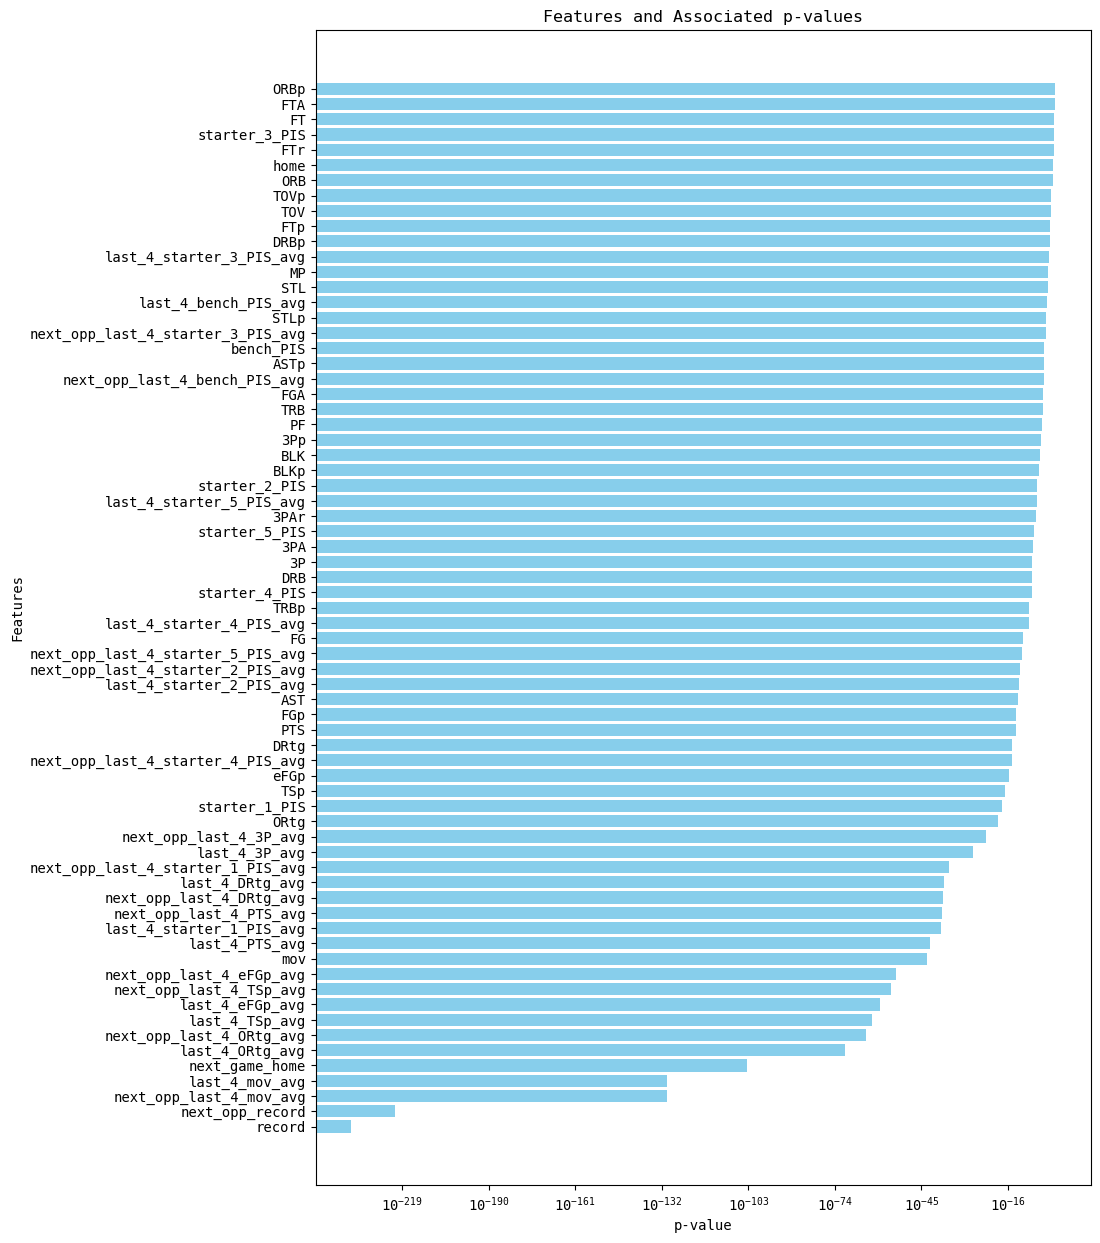

In [19]:
### Uncomment/comment to show/hide bar graph of features and their 
### significance relative to all the other features

# Create a bar chart
plt.rcParams['font.family'] = 'monospace'
plt.figure(figsize=(10, 15))  # Adjust the figure size as needed
plt.barh(sorted_features, sorted_p_values, color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Features')
plt.title('Features and Associated p-values')
plt.xscale('log')  # Scale the x-axis logarithmically
plt.show()

In [20]:
# Update Selected Indices (selected_indices) to only include the features with 0.05 or less p-values
selected_features = selected_features[p_values < 0.05]
p_values = p_values[p_values < 0.05]

sorted_indices = np.argsort(p_values)
sorted_features = selected_features[sorted_indices]
sorted_p_values = p_values[sorted_indices]

In [21]:
### Uncomment code below to view updated list of features

# for feature, p_value in zip(sorted_features, sorted_p_values):
#     print(f"{feature}: {p_value}")

<center><b>Correlation Analysis</b></center>

In [22]:
##### Create Correlation Matrix for selected list of features

# DataFrame with selected features
selected_df = X[sorted_features]

# Calculate correlation between features
corr_matrix = selected_df.corr(numeric_only=True)

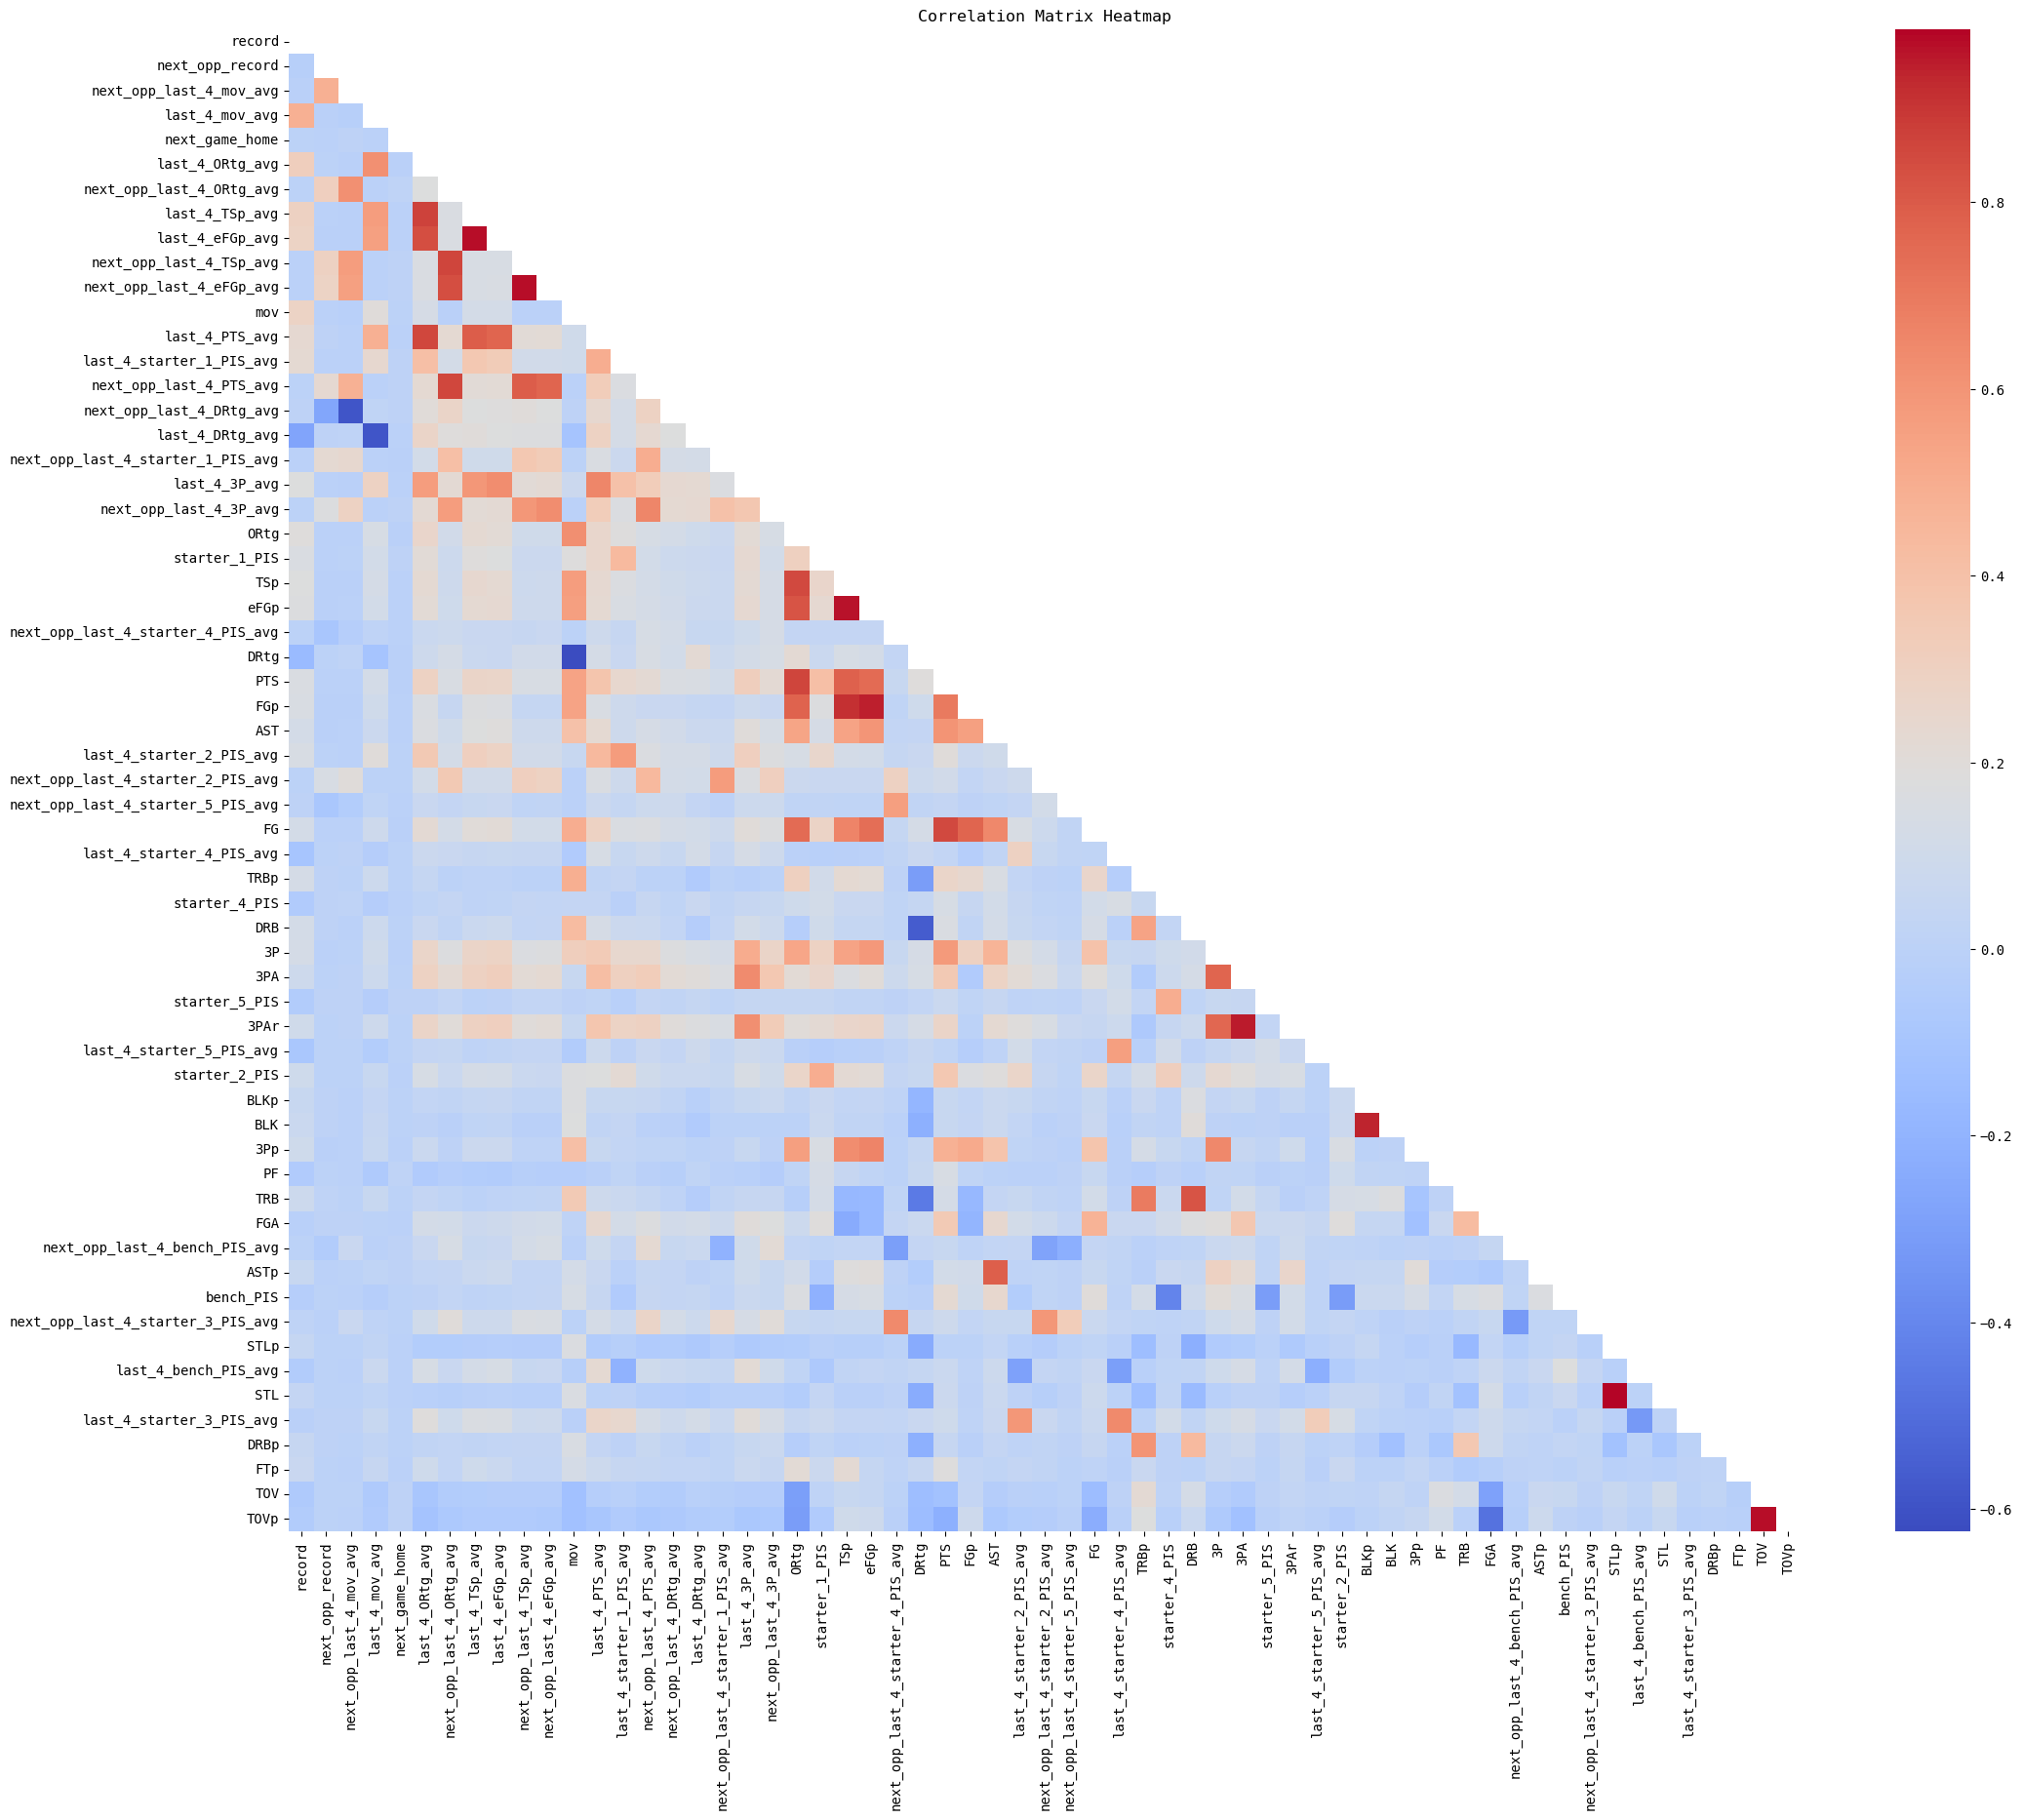

In [23]:
### Uncomment/Comment code below to view visual representation of Correlations

# Remove correlations with features and themselves
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create Plot
plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap')
plt.show()

In [24]:
##### Identify highly correlated Pairs

highly_correlated = (corr_matrix.abs() > 0.7) & (corr_matrix.abs() < 1.0)

# Iterate through each pair of highly correlated features
for i in range(len(highly_correlated.index)):
    for j in range(i+1, len(highly_correlated.columns)):
        if highly_correlated.iloc[i, j]:
            feature1 = highly_correlated.index[i]
            feature2 = highly_correlated.columns[j]
            correlation_value = corr_matrix.loc[feature1, feature2]
            p_value_feature1 = p_values[sorted_features == feature1][0]
            p_value_feature2 = p_values[sorted_features == feature2][0]
            
            ### Uncomment Print Statement if you would like to view the pairs listed out
            
            # print(f"{feature1} - {feature2}: Correlation = {correlation_value:.4f}")

In [25]:
##### Remove features from pairs of Highly Correlated Features with the higher p-value

# Initialize a list to store features to remove
remove = []

# Iterate through each highly correlated feature pair
for i in range(len(highly_correlated.index)):
    for j in range(i+1, len(highly_correlated.columns)):
        if highly_correlated.iloc[i, j]:
            feature1 = highly_correlated.index[i]
            feature2 = highly_correlated.columns[j]
            
            # Check the p-values of the features
            p_value_feature1 = p_values[selected_features == feature1][0]
            p_value_feature2 = p_values[selected_features == feature2][0]
            
            # Remove the feature with the higher p-value
            if p_value_feature1 >= p_value_feature2:
                remove.append(feature1)
            else:
                remove.append(feature2)

# Remove duplicate features from the list
remove = list(set(remove))

# Remove features from the main list of features
sorted_features = [feature for feature in sorted_features if feature not in remove]

In [26]:
### Uncomment line below to view the features being removed

remove

### Uncomment line below to view the updated list of selected features

# sorted_features

['last_4_TSp_avg',
 'next_opp_last_4_TSp_avg',
 'last_4_PTS_avg',
 'FGp',
 'eFGp',
 'next_opp_last_4_PTS_avg',
 'BLK',
 'STL',
 'last_4_eFGp_avg',
 'FG',
 'ASTp',
 '3PA',
 'TOVp',
 '3PAr',
 'TRB',
 'PTS',
 'TSp',
 'next_opp_last_4_eFGp_avg']

## Model Training and Testing

After completing the feature selection process, the next step is to train and test the machine learning model. In this project, we will use a Random Forest classifier to predict the outcomes of NBA games. Random Forest is an ensemble learning method that combines multiple decision trees to make predictions.

### Time Series Split

When training and testing a model for time series data, such as NBA game outcomes, it is crucial to use a proper validation technique that respects the temporal order of the data. Traditional cross-validation methods, such as k-fold cross-validation, assume that the data is independent and identically distributed, which is not the case for time series data.

In the context of NBA game predictions, using future games to predict past games would be unrealistic and lead to biased and overly optimistic results. It would be like using knowledge of future events to predict outcomes that have already occurred, which is not feasible in real-world scenarios.

<center><b>Define Function to Train and Test the model</b></center>

In [27]:
# The start parameter (start = 2) ensures that the model needs atleast 
# 2 seasons of data to predict the following season.

# The step parameter (step = 1) tells the model to move 1 season at a time

def train_test(data, model, predictors, start=2, step=1):
    # List predictions for a single season
    season_predictions = []
    
    # All seasons that exist in our dataframe
    seasons = sorted(data["season"].unique())
    
    # Loop through each season
    for i in range(start, len(seasons), step):
        season = seasons[i]
        
        ##### Training Data #####
        train = data[data['season'] < season]
        
        ##### Testing Data #####
        test = data[data['season'] == season]
        
        ##### Train Model on Training Data #####
        model.fit(train[predictors], train['target'])
        
        ##### Test Model on Testing Data #####
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        
        ##### Combine Model Predictions For Each Season #####
        combined = pd.concat([test['target'], preds], axis = 1)
        combined.columns = ['actual', 'prediction']
        season_predictions.append(combined)
        
    return pd.concat(season_predictions)

<center><b>Employ Function and Train/Test Model</b></center>

In [28]:
# Initialize RandomForestClassifier Model
rf_classifier = RandomForestClassifier(random_state=23)

# Employ Function on Model
predictions = train_test(nba_df, rf_classifier, sorted_features)

# Remove preductions where the actual value was 2 (since they had no next game)
predictions = predictions[predictions['actual'] != 2]

# Generate and Print Accuracy Score
accuracy = accuracy_score(predictions['actual'], predictions['prediction'])

accuracy_percent = accuracy * 100

print(f"Accuracy: {accuracy_percent}%")

Accuracy: 63.10832851054875%


## Hyperparameter Tuning

To improve the performance of the Random Forest classifier, we can perform hyperparameter tuning. Hyperparameter tuning involves searching for the optimal combination of hyperparameters that maximizes the model's performance. 

In this hyperparameter tuning process for the Random Forest Model, we will focus on the following hyperparameters:

1. `n_estimators`: This parameter represents the number of trees in the Random Forest. Increasing the number of trees can improve the model's performance, but it also increases the computational cost. We will search for the optimal value of `n_estimators` from the options [200, 225, 250, 275, 300].

2. `max_depth`: This parameter determines the maximum depth of each decision tree in the Random Forest. Increasing the maximum depth allows the trees to capture more complex relationships in the data, but it can also lead to overfitting. We will explore different values of `max_depth` from the options [8, 9, 10, 12, 14, 17].

3. `min_samples_split`: This parameter sets the minimum number of samples required to split an internal node in the decision trees. It controls the complexity of the trees and helps prevent overfitting. We will consider the values [2, 5, 10].

4. `min_samples_leaf`: This parameter defines the minimum number of samples required to be at a leaf node in the decision trees. It also helps control the complexity of the trees and prevents overfitting. We will search for the optimal value of `min_samples_leaf` from the options [1, 2, 4].

<center><b>Define Time Series Split Function</b></center>

In [29]:
# Define function that returns the splits for testing 
# and training, while considering that this is time-series data
def season_cv(data, n_splits=2):
    seasons = sorted(data["season"].unique())
    for i in range(n_splits, len(seasons)):
        train_idx = data[data["season"] < seasons[i]].index
        test_idx = data[data["season"] == seasons[i]].index
        yield train_idx, test_idx

<center><b>Define Different Hyperparameters To Test</b></center>

In [30]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 225, 250, 275, 300],
    'max_depth': [8, 9, 10, 12, 14, 17],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

<center><b>Perform Best Hyperparameter Search</b></center>
<b>Warning:</b> Do not run. This hyperparameter tuning is very computationally expensive. I have commented it out so that you do not accidentally run it. If you do intend to run it, uncomment the code and run it. (Estimated time on my device: ~ 30 minutes)

In [31]:
# # Instantiate the RandomizedSearchCV object
# random_search = RandomizedSearchCV(estimator=rf_classifier,
#                                    param_distributions=param_grid,
#                                    n_iter=270,
#                                    cv=season_cv(nba_df, n_splits=2),
#                                    scoring='accuracy',
#                                    n_jobs=-1,
#                                    random_state=23)

# # Fit the RandomizedSearchCV object
# random_search.fit(nba_df[sorted_features], nba_df['target'])

RandomizedSearchCV(cv=<generator object season_cv at 0x17fa0ebd0>,
                   estimator=RandomForestClassifier(random_state=23),
                   n_iter=270, n_jobs=-1,
                   param_distributions={'max_depth': [8, 9, 10, 12, 14, 17],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 225, 250, 275,
                                                         300]},
                   random_state=23, scoring='accuracy')

In [32]:
# # Get the best hyperparameters
# best_params = random_search.best_params_
# print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 8}


<center><b>Train/Test Model With Hyperparameters</b></center>

In [39]:
# Define the best hyperparameters
best_params = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 8}

# Initialize RandomForestClassifier with the best hyperparameters
rf_classifier = RandomForestClassifier(random_state=23, **best_params)

# Employ Function on Model
predictions = train_test(nba_df, rf_classifier, sorted_features)

# Remove preductions where the actual value was 2 (since they had no next game)
predictions = predictions[predictions['actual'] != 2]

# Generate and Print Accuracy Score
accuracy = accuracy_score(predictions['actual'], predictions['prediction'])

accuracy_percent = accuracy * 100

print(f"Accuracy: {accuracy_percent}%")

Accuracy: 64.09217656652812%


## Evaluating the Model

Now that we have trained and fine-tuned our Random Forest classifier, it's time to evaluate its performance using various evaluation metrics. We will create a confusion matrix and calculate precision, F1 score, and recall to assess how well the model predicts NBA game outcomes. Note: We have already measured the final accuracy after hyperparameter tuning.

__Accuracy__: 64.09743778607881%

### Creating a Confusion Matrix

A confusion matrix is a table that visualizes the performance of a classification model by comparing the predicted labels with the actual labels. It provides insights into the model's correct predictions and misclassifications.

In [40]:
##### Create Confusion Matrix

# Extract the actual values and predicted values from the predictions variable
actual_values = predictions['actual']
predicted_values = predictions['prediction']

# Create the confusion matrix
cm = confusion_matrix(actual_values, predicted_values)

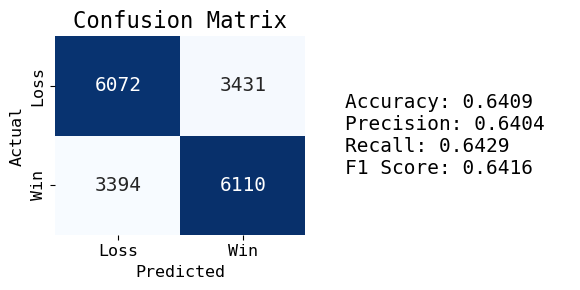

In [41]:
##### Print Graphic with Accuracy Measures

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=['Loss', 'Win'], columns=['Loss', 'Win'])

# Calculate the evaluation metrics
accuracy = accuracy_score(actual_values, predicted_values)
precision = precision_score(actual_values, predicted_values)
recall = recall_score(actual_values, predicted_values)
f1 = f1_score(actual_values, predicted_values)

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

# Plot the confusion matrix heatmap
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={'size': 14}, ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=16)
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
ax1.tick_params(axis='both', labelsize=12)

# Display the evaluation metrics
metrics_text = f'Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}'
ax2.text(0.1, 0.5, metrics_text, fontsize=14, va='center')
ax2.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Hypothesis Evaluation: Impact of 3-Point Statistics on Predictive Accuracy

### Hypothesis
The inclusion of 3-point statistics in the feature set will improve the predictive accuracy of the NBA game outcome model, particularly in more recent seasons.

### Rationale
In recent years, the NBA has witnessed a significant shift towards a more perimeter-oriented and 3-point focused style of play. Teams are increasingly relying on 3-point shooting as a key offensive strategy, with players taking more 3-point shots and teams prioritizing spacing and ball movement to create open 3-point opportunities.

The rationale behind the hypothesis is that as the 3-point shot has become more prevalent and important in the modern NBA, incorporating 3-point statistics into the predictive model should enhance its accuracy. The ability to effectively capture and utilize 3-point shooting data is expected to provide valuable insights into a team's offensive capabilities and overall performance.

Furthermore, it is hypothesized that the impact of 3-point statistics on predictive accuracy will become more pronounced in recent seasons compared to earlier seasons. As teams have adapted their playstyles and strategies to emphasize 3-point shooting, the predictive power of 3-point statistics is likely to have increased over time.

### Evaluation
To evaluate the hypothesis, we will compare the predictive accuracy of two models: one that includes 3-point statistics in the feature set and another that excludes them. The evaluation will be conducted across multiple NBA seasons to assess the impact of 3-point statistics on predictive accuracy over time.

<center><b>Train/Evaluate Current Model for Accuracy Per Season</b></center>

In [42]:
# List to store accuracy scores for each fold
accuracy_scores_with_3p = []

# Get the final train and test sets
for train_idx, test_idx in season_cv(nba_df, n_splits=2):
    X_train = nba_df[sorted_features].loc[train_idx]
    y_train = nba_df['target'].loc[train_idx]
    X_test = nba_df[sorted_features].loc[test_idx]
    y_test = nba_df['target'].loc[test_idx]

    # Get the season for the current test set
    test_season = nba_df['season'].loc[test_idx].unique()[0]

    # Train the model on the current fold
    rf_classifier.fit(X_train, y_train)

    # Evaluate the model on the test set
    predictions = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores_with_3p.append(accuracy)

<center><b>Train/Evaluate Model Without 3-Point Statistics for Accuracy Per Season</b></center>

In [43]:
# Remove 3 point related features
features_without_3p_stats = sorted_features.copy()
features_without_3p_stats = [feature for feature in features_without_3p_stats if feature not in ['last_4_3P_avg', 'next_opp_last_4_3P_avg', '3P', '3Pp']]

# List to store accuracy scores for each fold
accuracy_scores_without_3p = []

# Get the final train and test sets
for train_idx, test_idx in season_cv(nba_df, n_splits=2):
    X_train = nba_df[features_without_3p_stats].loc[train_idx]
    y_train = nba_df['target'].loc[train_idx]
    X_test = nba_df[features_without_3p_stats].loc[test_idx]
    y_test = nba_df['target'].loc[test_idx]

    # Get the season for the current test set
    test_season = nba_df['season'].loc[test_idx].unique()[0]

    # Train the model on the current fold
    rf_classifier.fit(X_train, y_train)

    # Evaluate the model on the test set
    predictions = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores_without_3p.append(accuracy)

<center><b>Plot Table To Perform Visual Comparisons</b></center>

In [44]:
# Create a list of seasons
seasons = ['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023']

# Create a DataFrame
data = {
    'Season': seasons,
    'Accuracy Score (with 3P)': accuracy_scores_with_3p,
    'Accuracy Score (without 3P)': accuracy_scores_without_3p
}
df = pd.DataFrame(data)

# Calculate the difference in accuracy scores
df['Accuracy Difference'] = df['Accuracy Score (without 3P)'] - df['Accuracy Score (with 3P)']

# Set the 'Season' column as the index
df.set_index('Season', inplace=True)

# Define custom colors
header_color = '#333333'  # Dark gray color for header
even_color = '#F5F5F5'     # Light gray color for even rows
odd_color = '#FFFFFF'      # White color for odd rows

# Style the DataFrame
df = df.style.set_properties(**{'background-color': even_color, 'color': 'black'})\
                    .set_properties(subset=['Accuracy Score (without 3P)', 'Accuracy Difference'],
                                    **{'background-color': odd_color})\
                    .format({'Accuracy Score (with 3P)': '{:.4f}',
                             'Accuracy Score (without 3P)': '{:.4f}',
                             'Accuracy Difference': '{:.4f}'})\
                    .set_properties(**{'text-align': 'center', 'font-family': 'Arial'})\
                    .set_table_styles([{'selector': 'th', 'props': [('background-color', header_color),
                                                                     ('color', 'white'),
                                                                     ('text-align', 'center')]}])

# Display the styled DataFrame
df

,Accuracy Score (with 3P),Accuracy Score (without 3P),Accuracy Difference
Season,,,
2015-2016,0.6561,0.6520,-0.0041
2016-2017,0.6313,0.6215,-0.0098
2017-2018,0.6630,0.6581,-0.0049
2018-2019,0.6484,0.6435,-0.0049
2019-2020,0.6398,0.6449,0.0052
2020-2021,0.6245,0.6181,-0.0065
2021-2022,0.6463,0.6431,-0.0033
2022-2023,0.6080,0.6096,0.0016
